# Clustering techniques detecting atypical network connections

We refer to a dataset downloaded from the 1999 KDD cup competition. We start by sampling from all available data so as to be able to work interactively.

In [3]:
# this is meant to be run on google colab

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

raw_data = sc.textFile('kddcup.data_10_percent.gz').sample(False, .01)

--2020-04-01 09:40:49--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz’

kddcup.data_10_perc 100%[===================>]   2.04M  1.97MB/s    in 1.0s    

2020-04-01 09:40:51 (1.97 MB/s) - ‘kddcup.data_10_percent.gz’ saved [2144903/2144903]



How many data do we have?

In [5]:
raw_data.count()

4863

What kind of data do we have?

In [6]:
raw_data.first()

'0,tcp,http,SF,236,1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,184,255,1.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,normal.'

Each element is a CSV (comma separated values) gathering 38 elements, mostly numeric ones. Let's import this data in a python list and peek through the first ten items.

In [8]:
original_data = raw_data.collect()
original_data[:10]

['0,tcp,http,SF,236,1680,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,184,255,1.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,334,1718,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,343,1544,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,36,36,0.00,0.00,0.00,0.00,1.00,0.00,0.00,142,255,1.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,209,751,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,11,0.00,0.00,0.00,0.00,1.00,0.00,0.18,101,255,1.00,0.00,0.01,0.04,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,303,316,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,7,0.00,0.00,0.00,0.00,1.00,0.00,0.29,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,317,6329,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6,6,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,255,1.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00,normal.',
 '0,tcp,finger,SF,6,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,

Each data item is represented by a string, but we want to be able to access to the single values deparated by commas, thus we start by splitting at each comma.

In [9]:
original_data[0].split(',')

['0',
 'tcp',
 'http',
 'SF',
 '236',
 '1680',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '3',
 '3',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 '1.00',
 '0.00',
 '0.00',
 '184',
 '255',
 '1.00',
 '0.00',
 '0.01',
 '0.02',
 '0.00',
 '0.00',
 '0.00',
 '0.00',
 'normal.']

More precisely, we should also address the conversion on numerical values. To to this properly, we use a function taking as argument a line and returning the corresponding list containing the converted elements between commas.

In [10]:
def clean(line):
    splitted_line = line.split(',')
    return [float(splitted_line[0])] + splitted_line[1:4] + [float(d) for d in splitted_line[5:-1]] + [splitted_line[-1]]

clean(original_data[0])

[0.0,
 'tcp',
 'http',
 'SF',
 1680.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 184.0,
 255.0,
 1.0,
 0.0,
 0.01,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 'normal.']

We can now map the cleaining function to each line in the original dataset, in order to obtain a cleaned data set to be further processed.

In [0]:
data = list(map(clean, original_data))

Let's explore how some of the quantities in the dataset behave. For instance, if for each element we consider the 30-th and the 31-th elements and interpret them as coordinates of a point, we can describe this element through a point in the plane:

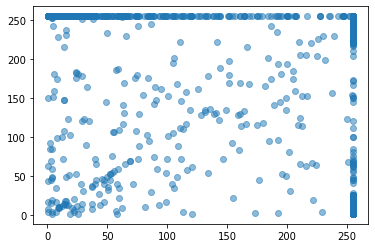

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

x_index, y_index = (30, 31)
x_points = [d[x_index] for d in data]
y_points = [d[y_index] for d in data]

plt.scatter(x_points, y_points, alpha=0.5)
plt.show()

We can see some interesting structure. Let's organize in order to be able to quickly check what happens if we focus on different components of each element in the dataset.

In [0]:
def scatter_plot(data, x_index, y_index):

    x_points = [d[x_index] for d in data]
    y_points = [d[y_index] for d in data]
    return plt.scatter(x_points, y_points, alpha=0.5)

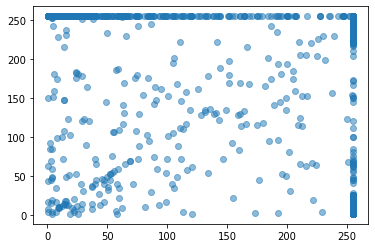

In [27]:
scatter_plot(data, 30, 31)
plt.show()

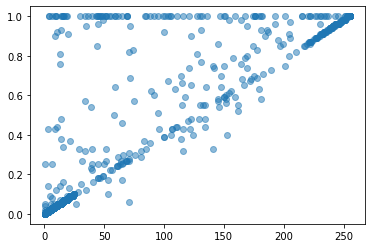

In [28]:
scatter_plot(data, 31, 32)
plt.show()

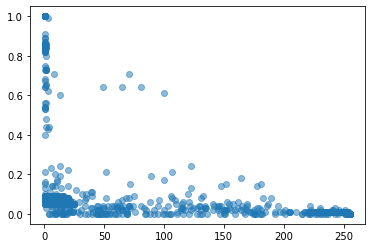

In [29]:
scatter_plot(data, 31, 33)
plt.show()

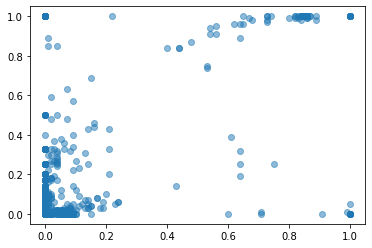

In [30]:
scatter_plot(data, 33, 34)
plt.show()

We see that points in the last graph tend to concentrate in different regions. We can apply a clustering algorithm in order to get more information about such regions.

The mathematical condition for the $K$ clusters $C_k$ and the $K$ centroids $\mu_k$ can be expressed as:

$$ \text{Minimize} \displaystyle \sum_{k=1}^K \sum_{\mathrm{x}_n \in C_k} ||\mathrm{x}_n - \mu_k ||^2 \text{ with respect to } \displaystyle C_k, \mu_k $$

An iterative method known as Lloyd’s algorithm exists that converges (albeit to a local minimum) in few steps. The procedure alternates between two operations.

* Once a set of centroids $\mu_k$ is available, the clusters are updated to contain the points closest in distance to each centroid:

$$ \displaystyle C_k = \{\mathrm{x}_n : ||\mathrm{x}_n - \mu_k|| \leq \mathrm{\,\,all\,\,} ||\mathrm{x}_n - \mu_l||\} $$

* Given a set of clusters, the centroids are recalculated as the means of all points belonging to a cluster:

$$ \displaystyle \mu_k = \frac{1}{C_k}\sum_{\mathrm{x}_n \in C_k}\mathrm{x}_n $$

The two-step procedure continues until the assignments of clusters and centroids no longer change.

In [0]:
import numpy as np
import random

from datetime import datetime
random.seed(datetime.now())
 
def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 

In [0]:
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu

In [0]:
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))

In [0]:
def find_centers(X, K):
    # Initialize to K random centers
    oldmu = random.sample(X, K)
    mu = random.sample(X, K)
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)

    return(mu, clusters)

In [0]:
K = 2
X = [np.array( (d[33], d[34]) ) for d in data]

oldmu = random.sample(X, K)
mu = random.sample(X, K)
clusters = cluster_points(X, mu)
mu = reevaluate_centers(oldmu, clusters)

In [41]:
clusters.keys()

dict_keys([0, 1])

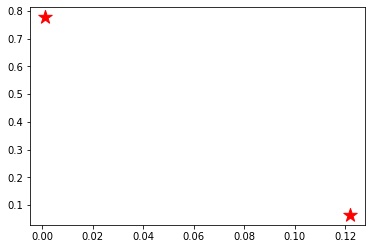

In [43]:
mu_x = [m[0] for m in mu]
mu_y = [m[1] for m in mu]
plt.scatter(mu_x, mu_y, marker="*", s=200, c='red')
plt.show()

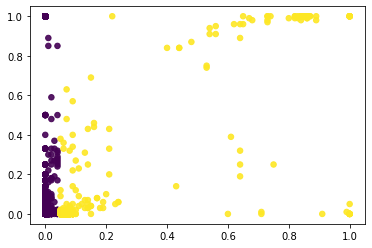

In [44]:
points_x = [d[0] for k in clusters.keys() for d in clusters[k] ]
points_y = [d[1] for k in clusters.keys() for d in clusters[k] ]

colors = [1.*k/len(clusters.keys()) for k in clusters.keys() for d in clusters[k] ]
plt.scatter(points_x, points_y, alpha=0.9, c=colors, s=30)
plt.show()

In [0]:
def show_clustering(mu, clusters):
    mu_x = [m[0] for m in mu]
    mu_y = [m[1] for m in mu]
    
    points_x = [d[0] for k in clusters.keys() for d in clusters[k] ]
    points_y = [d[1] for k in clusters.keys() for d in clusters[k] ]

    colors = [1.*k/len(clusters.keys()) for k in clusters.keys() for d in clusters[k] ]
    
    plt.scatter(points_x, points_y, alpha=0.9, c=colors, s=30)
    plt.scatter(mu_x, mu_y, marker="*", s=200, c='red')
    
    return plt

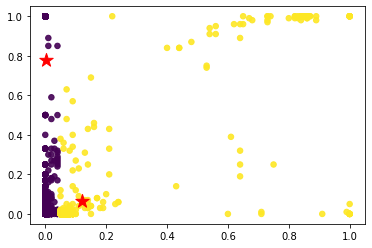

In [46]:
show_clustering(mu, clusters)
plt.show()

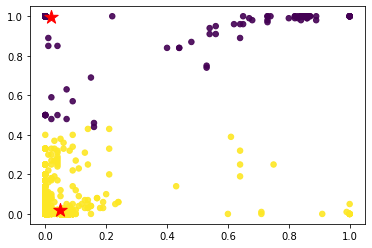

In [47]:
oldmu = mu
clusters = cluster_points(X, mu)
mu = reevaluate_centers(oldmu, clusters)
show_clustering(mu, clusters)
plt.show()

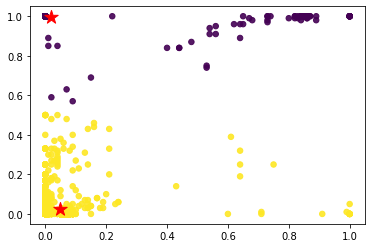

In [48]:
oldmu = mu
clusters = cluster_points(X, mu)
mu = reevaluate_centers(oldmu, clusters)
show_clustering(mu, clusters)
plt.show()

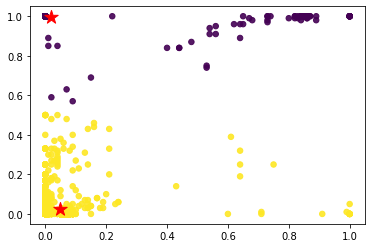

In [49]:
oldmu = mu
clusters = cluster_points(X, mu)
mu = reevaluate_centers(oldmu, clusters)
show_clustering(mu, clusters)
plt.show()

What would happen if we would use, say, $k=5$?

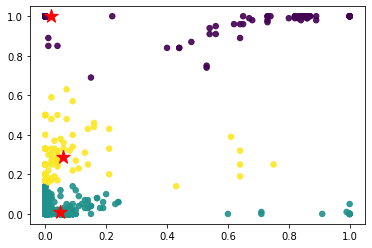

In [50]:
K = 5
X = [np.array( (d[33], d[34]) ) for d in data]

mu, clusters = find_centers(X, K)

show_clustering(mu, clusters)
plt.show()

Let's use the clustering procedures provided within spark MLlib.

In [0]:
from pyspark.mllib.clustering import KMeans

We start by checking how data distributes over the available labels

In [56]:
count = raw_data.map(lambda line: line.split(',')[-1]).countByValue()
sorted(list(count.items()), key=lambda e: -e[1])

[('smurf.', 2767),
 ('neptune.', 1044),
 ('normal.', 962),
 ('back.', 24),
 ('teardrop.', 21),
 ('portsweep.', 15),
 ('ipsweep.', 13),
 ('satan.', 11),
 ('warezclient.', 3),
 ('ftp_write.', 1),
 ('nmap.', 1),
 ('pod.', 1)]

The next step consists in converting each data in a vector of pure numbers. We'll simply ignore non-numerical items. We also extract the last item from each line, denoting a label for the corresponding network connection.

In [0]:
from pyspark.mllib.linalg import Vectors

def to_example(line):
    elements = line.split(',')
    vector = Vectors.dense([float(f) for f in [elements[0]] + elements[4:-1]])
    label = elements[-1]
    return (label, vector)
    
labels_and_data = raw_data.map(to_example)
data = labels_and_data.values().cache()

As a first attempt, let's group using two clusters

In [0]:
model = KMeans.train(data, 2)

In [59]:
model.clusterCenters

[array([4.61410942e+01, 9.30050596e+02, 6.90662485e+02, 0.00000000e+00,
        1.31633073e-02, 0.00000000e+00, 2.73549979e-02, 0.00000000e+00,
        1.47881530e-01, 4.93624023e-03, 0.00000000e+00, 0.00000000e+00,
        1.64541341e-03, 0.00000000e+00, 2.05676676e-04, 8.22706705e-04,
        0.00000000e+00, 0.00000000e+00, 1.23406006e-03, 3.32396339e+02,
        2.93375566e+02, 1.81116824e-01, 1.81176471e-01, 5.04113534e-02,
        5.04956808e-02, 7.93543809e-01, 1.99897162e-02, 3.11373920e-02,
        2.31922666e+02, 1.88871452e+02, 7.55174825e-01, 3.09132044e-02,
        6.01478815e-01, 6.67215138e-03, 1.80723982e-01, 1.80705471e-01,
        5.19354175e-02, 5.07322090e-02]),
 array([6.40000e+01, 7.25000e+02, 2.29337e+06, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        1.00000e+0

As a first evaluation of the goodness of the obtained clustering, let's check how many points fall in the two clusters, grouping the former according to their label:

In [0]:
cluster_label_count = labels_and_data.map(lambda e: (model.predict(e[1]), e[0])).countByValue()

In [66]:
for (cluster, label), count in sorted(cluster_label_count.items()):
    print('{}\t{:15s}\t{}'.format(cluster, label, count))

0	back.          	24
0	ftp_write.     	1
0	ipsweep.       	13
0	neptune.       	1044
0	nmap.          	1
0	normal.        	961
0	pod.           	1
0	portsweep.     	15
0	satan.         	11
0	smurf.         	2767
0	teardrop.      	21
0	warezclient.   	3
1	normal.        	1


The result isn't that good: most of items are contained in one of the clusters. Let's try to measure how good a clustering is, computing the average distance of points w.r.t. the assigned centroid's cluster.

In [0]:
import math

def distance(a, b):
    return math.sqrt(sum([e**2 for e in a-b]))

def dist_to_centroid(item, model):
    cluster = model.predict(item)
    centroid = model.clusterCenters[cluster]
    return distance(centroid, item)

We can use this measure in order to evaluate how many clusters should be used: we start by writing a function building a clustering from data (using a given number of clusters), and returns the average distance measure.

In [0]:
def clustering_score(data, k, epsilon=1e-4):
    model = KMeans.train(data, k, runs=runs, epsilon=epsilon)
    return data.map(lambda item: dist_to_centroid(item, model)).mean()

In [0]:
performance = [(k, clustering_score(data, k)) for k in range(5, 40, 5)]

In [70]:
performance

[(5, 1322.2924614789038),
 (10, 739.7495956949363),
 (15, 374.95543152231096),
 (20, 349.40534404651896),
 (25, 279.5652375539504),
 (30, 349.2495601936975),
 (35, 218.83444735554502)]

Thus the average distance decreases when the number of clusters increases. That is more than reasonable (should we use a number of clusters as big as the number of points, we would probably have each of the clusters centered on a point, and thus a null average distance). We can exploit this fact, increasing the number $k$ of clusters and stopping when we don't have significant amounts in the decrease of the average distance.

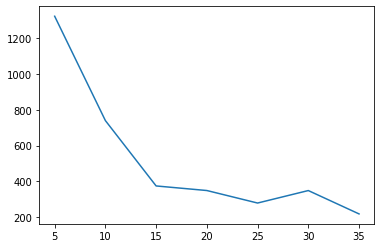

In [71]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.plot(*zip(*performance))
plt.show()

We typically call such a point in the graph an *ankle*, and in the above picture a good candidate for the ankle could be in correspondence the final part of the graph. We can check this fact by generating again this graph, now using a higher range for $k$.

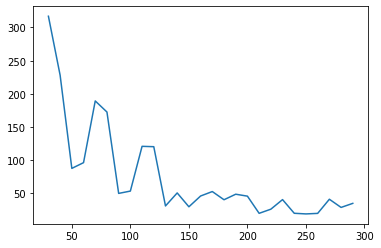

In [125]:
performance = [(k, clustering_score(data, k, epsilon=1e-4)) for k in range(30, 300, 10)]
plt.plot(*zip(*performance))
plt.show()

The graph suggests $k=130$ as the optimal value. Let's compute the clustering for the optimal value of the number of clusters.

In [0]:
model = KMeans.train(data, 130, epsilon=1e-6)

The points we are clustering belong to a space with dimenstion $38$, thus it is not possible to show them in a graph together with the cluster centroids, thus being able to validate or refute the obtained result. However, we can project each point in a 3D space. We will use a theoric result showing that, fixed $s \geq 3$ and defining the generic element $m_{ij}$ of the projecting matrix as

\begin{equation}
m_{ij} = \begin{cases}
+1 & \text{with probability $\frac{1}{2 s}$} \\
0  & \text{with probability $1-\frac{1}{s}$} \\
-1 & \text{with probability $\frac{1}{2 s}$}
\end{cases},
\end{equation}

on the average the distances between the projected points will reflect distances in the original space.

In [0]:
import random as rnd

def sparse_random_projection(s, n, k):
    '''from Ping Li, Trevor Hastie and Kenneth Church,
    Very Sparse Random Projections, KDD ’06
    
    s: projection parameter (should be geq 3)
    n: original space dimension
    k: reduced space dimension
    '''
    def prob(s):
        u = rnd.random()
        return 1 if u < 1. / (2*s) else -1 if u < 2. / (2*s) else 0
    
    return np.matrix([[prob(s) for i in range(n)] for j in range(k)])

def project(matrix, point):
    return list(matrix.dot(point).getA()[0])

The `project` function handles the projection of one object in the 3D space, returning the projected point expressed as alist. We are now able to project all points and color them according to the cluster they have been assigned to.

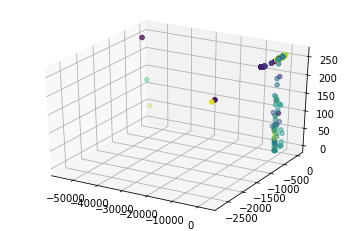

In [76]:
clusters = data.map(lambda item: (np.array(item), model.predict(item))).sample(False, .1).collect()
points, colors = zip(*clusters)

matrix = sparse_random_projection(3, len(points[0]), 3)
xs, ys, zs = zip(*[project(matrix, p) for p in points])

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=colors)
plt.show()

We see how the variance over one dimension is significantly higher than that on the remaining dimensions. This suggests us that data should be normalized before recomputing the clustering.

In [0]:
def build_normalization_function(data):
    data_as_list = data.map(list)
    num_cols = len(data_as_list.first())
    n = data_as_list.count()
    sums = data_as_list.reduce(lambda a, b: [ai+bi for ai, bi in zip(a, b)])
    sumsquares = data_as_list.map(lambda v: [vi**2 for vi in v]).reduce(lambda a, b: [ai+bi for ai, bi in zip(a, b)])
    stdevs = [math.sqrt(n*ss - s*s)/n for ss, s in zip(sumsquares, sums)]
    means = [s/n for s in sums]
    
    return lambda item: Vectors.dense([0 if s==0 else (i - m)/s for i, m, s in zip(item, means, stdevs)])

In [0]:
normalize = build_normalization_function(data)
normalized_data = data.map(normalize).cache()

In [0]:
performance = [(k, clustering_score(normalized_data, k)) for k in range(150, 400, 20)]

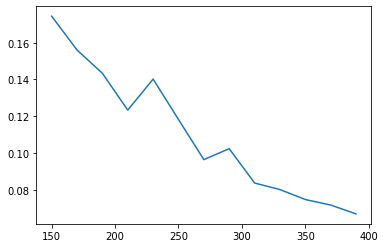

In [138]:
plt.plot(*zip(*performance))
plt.show()

This graph suggests $k=300$ as an optimal number of clusters. Let's compute the optimal clustering and show the corresponding projected data.

In [0]:
model = KMeans.train(normalized_data, 300)

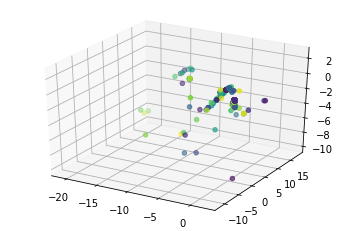

In [140]:
clusters = normalized_data.map(lambda item: (np.array(item), model.predict(item))).sample(False, .1).collect()
points, colors = zip(*clusters)

matrix = sparse_random_projection(3, len(points[0]), 3)
xs, ys, zs = zip(*[project(matrix, p) for p in points])

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=colors)
plt.show()

We can compute the average entropy for points in a same cluster, and use the result as an alternate value of the clustering performance.

In [0]:
def entropy(counts):
    values = [c for c in counts if c>0]
    n = float(sum(values))
    return sum([-v/n * math.log(v/n) for v in values])

In [0]:
from itertools import groupby

def clustering_score_entropy(normalized_labels_and_data, k, runs=1, epsilon=1e-4):
    model = KMeans.train(normalized_labels_and_data.values(), k, runs=runs, epsilon=epsilon)
    labels_and_clusters = normalized_labels_and_data.mapValues(model.predict)
    clusters_and_labels = labels_and_clusters.map(lambda i: list(reversed(i)))
    labels_in_clusters = clusters_and_labels.groupByKey().values()
    label_counts = labels_in_clusters.map(lambda l: [len(list(v)) for k, v in groupby(sorted(l))])
    n = normalized_labels_and_data.count()
    return label_counts.map(lambda m: sum(m) * entropy(m)).sum() / n

In [0]:
def build_categorical_data_and_label(raw_data):
    split_data = raw_data.map(lambda line: line.split(','))
    protocols_list = split_data.map(lambda line: line[1]).distinct().collect()
    protocols = dict(zip(protocols_list, range(len(protocols_list))))
    
    services_list = split_data.map(lambda line: line[2]).distinct().collect()
    services = dict(zip(services_list, range(len(services_list))))
    
    tcp_states_list = split_data.map(lambda line: line[3]).distinct().collect()
    tcp_states = dict(zip(tcp_states_list, range(len(tcp_states_list))))
    
    def to_categorical_data_and_label(line):
        buf = line.split(',')
        protocol = buf.pop(1)
        service = buf.pop(1)
        tcp_state = buf.pop(1)
        label = buf.pop()
        vector = [float(f) for f in buf]
        new_protocol_features = [0.] * len(protocols)
        new_protocol_features[protocols[protocol]] = 1.0
        new_service_features = [0.] * len(services)
        new_service_features[services[service]] = 1.0
        new_tcp_states_features = [0.] * len(tcp_states)
        new_tcp_states_features[tcp_states[tcp_state]] = 1.0
        
        vector[1:1] = new_tcp_states_features
        vector[1:1] = new_service_features
        vector[1:1] = new_protocol_features
        
        return (label, Vectors.dense(vector))
    return to_categorical_data_and_label

In [0]:
to_categorical_data_and_label = build_categorical_data_and_label(raw_data)
labels_and_data = raw_data.map(to_categorical_data_and_label)
normalize = build_normalization_function(labels_and_data.values())
normalized_labels_and_data = labels_and_data.mapValues(normalize).cache()

performance = [(k, clustering_score_entropy(normalized_labels_and_data, k)) for k in range(150, 300, 20)]

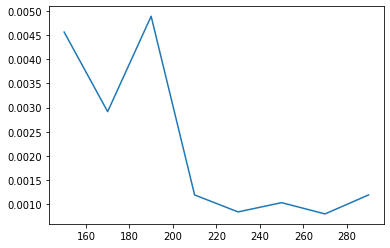

In [131]:
plt.plot(*zip(*performance))
plt.show()

Let's use $k=220$ in order to build the clustering, and let's check as in the beginning of the tutorial how many points belong to each cluster, grouping the results with labels.

In [0]:
model = KMeans.train(normalized_labels_and_data.values(), 220)

In [0]:
cluster_label_count = normalized_labels_and_data.map(lambda e: (model.predict(e[1]), e[0])).countByValue()

In [134]:
for (cluster, label), count in sorted(cluster_label_count.items()):
    print('{}\t{:15s}\t{}'.format(cluster, label, count))

0	neptune.       	153
1	smurf.         	2579
2	normal.        	1
3	neptune.       	1
4	neptune.       	1
5	neptune.       	2
6	normal.        	1
7	normal.        	10
8	normal.        	4
9	normal.        	5
10	neptune.       	3
11	normal.        	7
12	portsweep.     	3
13	normal.        	1
14	neptune.       	1
15	normal.        	2
16	neptune.       	1
17	normal.        	1
18	normal.        	1
19	neptune.       	1
20	normal.        	1
21	neptune.       	1
22	neptune.       	1
23	neptune.       	1
24	neptune.       	72
25	neptune.       	1
26	neptune.       	2
27	normal.        	1
28	ipsweep.       	8
29	normal.        	10
29	warezclient.   	1
30	teardrop.      	1
31	neptune.       	2
32	neptune.       	1
33	normal.        	1
34	ipsweep.       	2
35	normal.        	133
36	back.          	10
37	neptune.       	2
38	neptune.       	1
39	neptune.       	1
40	normal.        	4
41	neptune.       	1
42	neptune.       	1
43	neptune.       	1
44	neptune.       	1
45	neptune.       	1
46	normal.  

We can now use this clustering in order to build a detector of anomalous network connections. The basic idea is that of filtering points whose distance from the center of the assigned cluster is higher than a specific threshold value. Such value can be found sorting the distances w.r.t. centers and use the 100-th one as threshold.

In [0]:
distances = normalized_labels_and_data.values().map(lambda item: dist_to_centroid(item, model))
threshold = distances.top(100)[-1]
def is_anomalous(item):
    return dist_to_centroid(item, model) > threshold

We can now filter the connections according to our anomaly detection criterion and show, say, 10 of the filtered ones.

In [136]:
normalized_labels_and_data.values().filter(is_anomalous).take(10)

[DenseVector([-0.066, 1.2712, -0.214, -1.1606, 2.5573, -0.0454, -0.1365, -0.106, -1.1504, -0.5403, -0.0287, -0.0933, -0.0537, -0.0351, -0.0143, -0.0248, -0.0287, -0.0351, -0.1191, -0.038, -0.0143, -0.0203, -0.0143, -0.0143, -0.0143, -0.0203, -0.0203, -0.0203, -0.0203, -0.0248, -0.0248, -0.0203, -0.0203, -0.0143, -0.0203, -0.0248, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, -0.0143, 0.5486, -0.0203, -0.2218, -0.47, -0.0431, -0.0351, -0.1416, 1.4585, 0.0, -0.0667, 0.0, -0.0428, 0.0, 2.3988, -0.0704, 0.0, 0.0, -0.0186, 0.0, -0.0143, -0.0287, 0.0, 0.0, -0.0351, -1.522, -1.1593, -0.4711, -0.4708, -0.2315, -0.2316, 0.5338, -0.2648, -0.211, -3.408, 0.6249, 0.5976, -0.2818, -1.0005, 0.3331, -0.4706, -0.47, -0.238, -0.2336]),
 DenseVector([-0.066, 1.2712, -0.214, -1.1606, 2.5573, -0.0454, -0.1365, -0.106, -1.1504, -0.5403, -0.0287, -0.0933, -0.0537, -0.0351, -0.0143, -0.0248, -0.0287, -0.0351, -0.1191, -0.038, -0.0143, -0.0203, -0.0143, -0.0143, -0.